# Deep Learning - Report 1
This is a template notebook of your report. Please complete your report with your team mate following these instructions:
- Work on the exercies below by filling the notebook.
- **Rename your notebook** in the format `FirstName1FAMILYNAME1_FirstName2FAMILYNAME2_report1.ipynb`. For example, when the team consists of Johann FAOUZI and Ikko Yamane, the file name should look like `JohannFAOUZI_IkkoYAMANE_report1.ipynb`.
- You are only allowed to edit new cells you have added (except the "Solution to Exercise 0" cell).
- Write `### Solution to Exercise (number)` at the beginning of each cell you add.
- Please submit your notebook on Moodle.
- The submission deadline is 17:00 (UTC+2) of September 19, 2023.
- Explain your code with comment or/and markdown. The explanations will be taken into account for the evaluation.

## Exercise 0
- Rename your notebook in the format `FirstName1FAMILYNAME1_FirstName2FAMILYNAME2_report1.ipynb`.
- Write your names and email addresses.

### Solution to Exercise 0
- Name of Author 1:
- Name of Author 2:
- Email address of Author 1:
- Email address of Author 2:

## CIFAR-10
We are going to work on the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) [Krizhevsky 2009].

For the purpose of testing your skills, we are going to directly download an original dataset and manually adapt it to the PyTorch format. The following three cells download the data, create NumPy arrays of them, and show examples. The `load_cifar10` function converts the color images to gray-scale ones when `color=False`.

[Krizhevsky 2009] [Learning Multiple Layers of Features from Tiny Images, Alex Krizhevsky, 2009.](https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf)

In [107]:
import pickle
import numpy as np
import urllib.request
import tarfile
import os.path
from pathlib import Path

def download_cifar10():
    filename = 'cifar-10.tar.gz'
    if os.path.isfile(filename):
        print(f'{filename} already exists. Skipping downloading.')
        return

    url = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'

    with urllib.request.urlopen(url) as testfile, open('cifar-10.tar.gz', 'wb') as f:
        f.write(testfile.read())


def extract_cifar10(filename="cifar-10.tar.gz"):
    dirname = 'cifar-10-batches-py'
    if Path(dirname).is_dir():
        print(f'{dirname} already exists. Skipping extracting.')
        return

    tar = tarfile.open(filename)
    tar.extractall()
    tar.close()


def load_cifar10(train, dir='cifar-10-batches-py', color=False):
    data_raw = []
    if train:
        for i in range(5):
            with open(f'{dir}/data_batch_{i+1}', 'rb') as f:
                data_raw.append(pickle.load(f, encoding='bytes'))
        x = np.concatenate(
            [d[b'data'] for d in data_raw],
            axis=0)
        y = np.concatenate(
            [d[b'labels'] for d in data_raw],
            axis=0)
    else:
        with open(f'{dir}/test_batch', 'rb') as f:
            data_raw = pickle.load(f, encoding='bytes')
        x = np.array(data_raw[b'data'])
        y = np.array(data_raw[b'labels'])
        print(type(data_raw))

    x = np.reshape(x, newshape=(len(x), 3, 32, 32))
    if not color:
        x = x.mean(axis=1, keepdims=True)  # Convert Red-Green-Blue (RGB) images to gray-scale.
    return x, y

In [108]:
download_cifar10()
extract_cifar10()
x_train_val_np, y_train_val_np = load_cifar10(train=True)
x_test_np, y_test_np = load_cifar10(train=False)
print(np.unique(y_train_val_np))

cifar-10.tar.gz already exists. Skipping downloading.
cifar-10-batches-py already exists. Skipping extracting.
<class 'dict'>
[0 1 2 3 4 5 6 7 8 9]


['truck', 'truck', 'deer', 'automobile', 'automobile']


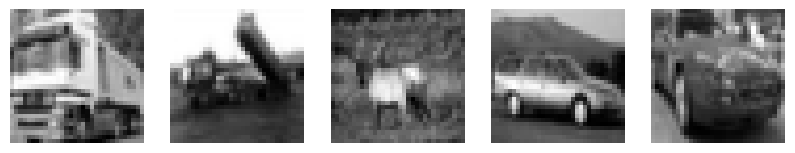

In [109]:
import matplotlib.pyplot as plt

id2class = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

def plot_images(x, y, rows=1, cols=5, color=False):
    figure = plt.figure(figsize=(2 * cols, 2 * rows))
    ys = []
    for i in range(rows):
        for j in range(cols):
            k = (i * cols) + j + 1
            figure.add_subplot(rows, cols, k)
            plt.axis("off")
            if color:
                plt.imshow(np.transpose(x[k], [1, 2, 0]))
            else:
                plt.imshow(np.transpose(x[k], [1, 2, 0]), cmap="gray")
            ys.append(y[k])
    print([id2class[id] for id in ys])
    plt.show()

plot_images(x_train_val_np, y_train_val_np, rows=1, cols=5)

In [110]:
from sklearn.model_selection import train_test_split
import numpy as np
import torch
from torchvision.transforms import ToTensor
from torchvision.transforms.v2 import ToDtype

## Exercise 1
Randomly split the dataset `(x_train_val_np, y_train_val_np)` to a training set `(x_train_np, y_train_np)` and a validation set `(x_val_np, y_val_np)`. Here, take `40000` data points for the training set and put the rest in the validation set.

In [111]:
x_train_np, x_val_np, y_train_np, y_val_np = train_test_split(
    x_train_val_np, y_train_val_np, train_size=40000,
    stratify=y_train_val_np, random_state=43
)
classes, counts = np.unique(y_train_np, return_counts=True)
print(counts/counts.sum())


[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


The result of train_test_split will be stored in four variables : Two subsets of features for training and validation and two subset of features for training and validation. We don't really need the stratification here because each class have the same proportion. Shuffle ensure that the training and the validation sets are random from the original set.

## Exercise 2
Write code to convert `x_train_np, y_train_np, x_val_np, y_val_np, x_test_np, y_test_np` to PyTorch Tensors.
Name the tensors as `x_train, y_train, x_val, y_val, x_test, y_test`, respectively.

**Note**: You may need to explicitly change the `dtype` of your tensors. PyTorch by default requires the type (`dtype`) of input tensor to be `torch.float32` and that of the labels to be `torch.int64`.

In [112]:
x_train = torch.from_numpy(x_train_np).to(dtype=torch.float32)
y_train = torch.from_numpy(y_train_np).to(dtype=torch.int64)  # Class labels are usually integers

x_val = torch.from_numpy(x_val_np).to(dtype=torch.float32)
y_val = torch.from_numpy(y_val_np).to(dtype=torch.int64)

x_test = torch.from_numpy(x_test_np).to(dtype=torch.float32)
y_test = torch.from_numpy(y_test_np).to(dtype=torch.int64)

## Exercise 3
Write a Python class `CustomDataset` deriving `torch.utils.data.Dataset` and create dataloaders for the training, validation, and test sets.

**Bonus** If possible, making the `transform` parameter and pass `ToTensor()` to it to avoid manually converting data to PyTorch tensors as in Exercise 2.

## Bonus

# Without transform

In [113]:
from torch.utils.data import DataLoader
########## avec les tenseurs. ##############
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self,x,y):
        self.x=x
        self.y=y

    def __len__(self):
        return self.y.size()[0]
# size()[0] return the dimension of the target because it is one dimensional

    def __getitem__(self,idx):
        x=self.x[idx]
        y=self.y[idx]
        return(x,y)


train= DataLoader(CustomDataset(x_train,y_train), batch_size=64, shuffle =True)
test = DataLoader(CustomDataset(x_test,y_test), batch_size=64, shuffle =True)
val = DataLoader(CustomDataset(x_val,y_val), batch_size=64, shuffle =True)


# With transform to tensor

In [114]:
class CustomDatasetNP(torch.utils.data.Dataset):
    """
        This class enable us to return iterable object that can be pass in the 
        dataloader
        It takes three attributes:
        x : features
        y : targets
        y : function that transform the PIL images or numpy.ndarray to a tensor object
    """
    def __init__(self,x,y,transform = None):
        self.x=x
        self.y=y
        self.transform=transform

    def __len__(self):
        ### le x n'est pas encore un tenseur donc on ne peut pas donner à
        ### le .size. La méthode size pour un numpy renvoie le nombre TOTAL d'éléments.
        ### Il faut dès lors donner comme longueur .shape[0].
        ### c'est à partir de cette longueur que l'on détermine la limite des
        ### idx.
        ###
        return(self.x.shape[0])
    def __getitem__(self,idx):
        x=self.x[idx]
        y=self.y[idx]
        if self.transform:
            x=self.transform(x).to(dtype=torch.float32)
        return(x,y)




train_alt = DataLoader(CustomDatasetNP(x_train_np,y_train_np, ToTensor()), batch_size=64, shuffle =True)

test_alt = DataLoader(CustomDatasetNP(x_test_np,y_test_np, ToTensor()), batch_size=64, shuffle =True)

val_alt = DataLoader(CustomDatasetNP(x_val_np,y_val_np, ToTensor()), batch_size=64, shuffle =True)




## Exercise 4
Let the variable `device` be `'cuda'` if CUDA (GPU) is available. Otherwise, let it be `'cpu'`.
(Do **not** move the tensors from Exercise 1 to this `device` yet.)

In [115]:
device  = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)

## Exercise 5
Write a Python class `MLP5` for Multi-Layer Perceptron (MLP) with 5 layers derivng from `nn.Module` or `nn.Sequencial`.
Your network must have the following sequential architecture:
- First hidden layer: Linear layer (64 output features) + ReLU activation function
- Second hidden layer: Linear layer (64 output features) + ReLU activation function
- Third hidden layer: Linear layer (64 output features) + ReLU activation function
- Forth hidden layer: Linear layer (64 output features) + ReLU activation function
- Final layer: Linear layer

Note that the final layer should have the output dimensionality equal to the number of classes in order to express class posterior probabilities.

In [116]:
import torch.nn as nn
import torch.nn.functional as F

class MLP5(nn.Module):
    """
        This is Multi-Layer perceptron(MLP) class which takes one attribute : the number of class of target
        number_classes : number of class of target
    """
    def __init__(self, number_classes):
        super().__init__()
        # We use the flattern to combine two set of information that reduce one dimension to get 32*32
        # Sequential enable us to apply sequentially many transformations
        self.transform1 = nn.Sequential(nn.Flatten(),nn.Linear(32*32,64),nn.ReLU())
        self.transform2 = nn.Sequential(nn.Linear(64,64),nn.ReLU())
        self.transform3 = nn.Linear(64,number_classes)
    def forward(self,x):
        """
            This function take a tensor object and return the vector of tensor with length : the number of classes
            x : tensor object
        """
        out = self.transform1(x)
        out = self.transform2(out)
        out = self.transform2(out)
        out = self.transform2(out)
        out = self.transform3(out)

        return out



# We have combine the exercice 6 and 7

## Exercise 6
- Write a Python function for training a model with mini-batch updates for one epoch. Do not forget to move your mini-batch data to `device`.
- Also, write Python function for evaluating the loss and the accuracy of a given model with a given dataloader.

# Definition of function to using during the DM

In [117]:
# Here the definition of the loss function that will enable us to update weight

loss_fn = nn.CrossEntropyLoss()
modele_MLP = MLP5(len(id2class)).to(device)
learningRate = 1e-7
optimizer = torch.optim.Adam(modele_MLP.parameters(), lr= learningRate )

# Here the function to train the model

def train_loop(dataloader,loss_fn, optimizer, modele,device):
    modele.train()
    perte_dataloader=0
    precision=0
    for batch, (X,y) in enumerate(dataloader):
        # pour chaque itération, on calcule la fonction de coût.
        X=X.to(device)

        y=y.to(device)

        predictions=modele(X)

        perte=loss_fn(predictions,y)

        perte.backward()

        optimizer.step()

        optimizer.zero_grad() # update weight

        perte_dataloader+=perte.item()

    print(batch,perte_dataloader)


def evaluate_loop(dataloader, model, loss_fn, device, set_='Validation'):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            # Move the tensors to `device`. For instance, it could be a GPU.
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"\n{set_} set: \n  Accuracy: {(100 * correct): >0.1f}%, Avg loss: {test_loss: >8f} \n")
    return (100*correct)



import numpy as np 
import torch as torch

list_learning_rate = [0.001, 0.0001, 1e-5,  1e-6, 1e-7, 1e-8,  1e-9]


# Function that return the learning rate after the turn

def fonction_renvoie_lr_rate(list_learning_rate, device , modele, train, val, number_class, loss_fn):

    """ Renvoyer le meilleur taux. 
    Parameters :
    ---------
    list_learning_rate : list. Liste des taux. 
    device : str. Cpu ou cuda. 
    modele : modele statistique. Il doit avoir comme attribut le nombre de classes de Y. 
    train : dataloader pour l'apprentissage. 
    val : dataloader pour la validation. 
    number_class : int. Nombre de classes pour Y (longueur(id2classes)) dans le tp.
    loss_fn : Function. fonction de coût/loss function. 

    Returns :
    ----
    float. Best learning rate. 
    """

    liste_precision = []
    for taux in list_learning_rate:
        # instancier le modèle avec les optimisateurs.
        
        precision_un_taux = []
        if number_class:
            modele_MPL = modele(number_class).to(device)
        else:
             modele_MPL = modele().to(device)
        optimizer = torch.optim.Adam(modele_MPL.parameters(), lr=taux)
        
        print(f"Le taux de learning est de {taux}")
        
        torch.manual_seed(133)  #The function torch.manual_seed() is 
        #used to initialize PyTorch's random number generator 
        #with a specific seed, ensuring that the outcomes of operations 
        #involving random numbers will be reproducible in CPU.


        for epoch in range(10):
            print(str(epoch)+"-------------------")
            # fonctions à coder. 
            train_loop(dataloader=train, optimizer=optimizer, loss_fn=loss_fn, modele=modele_MPL, device=device)
            precision = evaluate_loop(dataloader=val, loss_fn=loss_fn, model=modele_MPL, device=device)
            precision_un_taux.append(precision)
        # on récupère la précision moyenne avec le même taux. 
        selection = np.mean(np.array(precision_un_taux))
        # on ajoute cette moyenne. 
        liste_precision.append(selection)
        # on choisit le taux de précision moyenne maximale. 
    indice = np.argmax(np.array(liste_precision))
    # Fini !
    lr_rate_opt = list_learning_rate[indice]
    return(lr_rate_opt)




## Exercise 7
- Create an object using your class and keep it in the `modelMLP5` variable. Do not forget move your model to `device`.
- Choose any loss function.
- Create an optimizer for optimizing `modelMLP5`.
- Train `modelMLP5` with your function(s) for 10 epochs. During the training, print the training and validation loss/accuracy every epoch.

You may need to tune hyper-parameters such as the learning rate later while observing the behavior of the model during the training.

# Training of the model with learning rate =  1e-7 chosen randomly

In [118]:
for epoch in range(10):
    print(str(epoch)+"-------------------")
    train_loop(dataloader=train_alt,optimizer=optimizer,loss_fn=loss_fn,modele=modele_MLP,device=device)
    evaluate_loop(dataloader=val_alt,loss_fn=loss_fn,model=modele_MLP,device=device)


0-------------------
624 2057.9291501045227

Validation set: 
  Accuracy: 9.1%, Avg loss: 3.112059 

1-------------------
624 1874.33944439888

Validation set: 
  Accuracy: 10.0%, Avg loss: 2.904704 

2-------------------
624 1777.8602333068848

Validation set: 
  Accuracy: 10.8%, Avg loss: 2.792529 

3-------------------
624 1719.864489555359

Validation set: 
  Accuracy: 11.4%, Avg loss: 2.714020 

4-------------------
624 1675.7322175502777

Validation set: 
  Accuracy: 11.5%, Avg loss: 2.649324 

5-------------------
624 1637.2281668186188

Validation set: 
  Accuracy: 11.6%, Avg loss: 2.592182 

6-------------------
624 1602.2093014717102

Validation set: 
  Accuracy: 11.8%, Avg loss: 2.538395 

7-------------------
624 1571.03928399086

Validation set: 
  Accuracy: 11.9%, Avg loss: 2.494058 

8-------------------
624 1544.454086780548

Validation set: 
  Accuracy: 12.0%, Avg loss: 2.455312 

9-------------------
624 1522.7628066539764

Validation set: 
  Accuracy: 12.1%, Avg loss

# Turning of the MLP5 model

In [119]:

[0.001,0.0001, 1e-5,  1e-6 ,1e-7, 1e-8,  1e-9]

lr_rate_opt = fonction_renvoie_lr_rate(list_learning_rate =list_learning_rate,\
                         device = device, modele = MLP5, train = train,\
                         val = val, number_class = len(id2class), loss_fn=loss_fn)




Le taux de learning est de 0.001
0-------------------
624 1314.359148144722

Validation set: 
  Accuracy: 26.8%, Avg loss: 1.991418 

1-------------------
624 1228.080017209053

Validation set: 
  Accuracy: 29.8%, Avg loss: 1.945779 

2-------------------
624 1201.3127753734589

Validation set: 
  Accuracy: 31.1%, Avg loss: 1.908072 

3-------------------
624 1183.404344677925

Validation set: 
  Accuracy: 31.5%, Avg loss: 1.916778 

4-------------------
624 1173.649095773697

Validation set: 
  Accuracy: 32.7%, Avg loss: 1.882319 

5-------------------
624 1160.0710592269897

Validation set: 
  Accuracy: 31.1%, Avg loss: 1.921491 

6-------------------
624 1155.419777393341

Validation set: 
  Accuracy: 32.1%, Avg loss: 1.912946 

7-------------------
624 1142.6775510311127

Validation set: 
  Accuracy: 32.5%, Avg loss: 1.876046 

8-------------------
624 1141.0859252214432

Validation set: 
  Accuracy: 33.6%, Avg loss: 1.840461 

9-------------------
624 1131.5125943422318

Validatio

In [120]:
print(f"The learning rate is {lr_rate_opt}")

The learning rate is 0.0001


# Now we can use the optimal learning rate in the data test

In [121]:
modele_MLP = MLP5(len(id2class)).to(device)
optimizer = torch.optim.Adam(modele_MLP.parameters(), lr= lr_rate_opt )

torch.manual_seed(133)
for epoch in range(10):
    print(str(epoch)+"-------------------")
    train_loop(dataloader=train,optimizer=optimizer,loss_fn=loss_fn,modele=modele_MLP,device=device)
    evaluate_loop(dataloader=test,loss_fn=loss_fn,model=modele_MLP,device=device)


0-------------------
624 1327.8958134651184

Validation set: 
  Accuracy: 26.5%, Avg loss: 2.025335 

1-------------------
624 1241.5879427194595

Validation set: 
  Accuracy: 29.4%, Avg loss: 1.960112 

2-------------------
624 1204.2130961418152

Validation set: 
  Accuracy: 32.2%, Avg loss: 1.903934 

3-------------------
624 1179.5019606351852

Validation set: 
  Accuracy: 32.4%, Avg loss: 1.895991 

4-------------------
624 1163.8491501808167

Validation set: 
  Accuracy: 34.1%, Avg loss: 1.859964 

5-------------------
624 1150.017021894455

Validation set: 
  Accuracy: 33.6%, Avg loss: 1.846438 

6-------------------
624 1139.9697340726852

Validation set: 
  Accuracy: 33.6%, Avg loss: 1.846604 

7-------------------
624 1129.5699880123138

Validation set: 
  Accuracy: 34.5%, Avg loss: 1.829600 

8-------------------
624 1120.2726575136185

Validation set: 
  Accuracy: 35.0%, Avg loss: 1.809432 

9-------------------
624 1110.9400565624237

Validation set: 
  Accuracy: 35.6%, Av

## Exercise 8
Write a Python class `MLP5BN` similarly to `MLP5`, but put a batch normalization layer (`torch.nn.BatchNorm1d`) before every activation layer.
Then, create an object using your class and keep it in the `modelMLP5BN` variable. Train this model and compare the results for `modelMLP5` and `modelMLP5BN`.

In [122]:

class MLP5BN(nn.Module):
    def __init__(self,nombre_classes):
        super().__init__()
        self.transform1=nn.Sequential(nn.Flatten(),nn.Linear(32*32,64),torch.nn.BatchNorm1d(64),nn.ReLU())
        self.transform2=nn.Sequential(nn.Linear(64,64),torch.nn.BatchNorm1d(64),nn.ReLU())
        self.transform3=nn.Linear(64,nombre_classes)
    def forward(self,x):
        out=self.transform1(x)
        out=self.transform2(out)
        out=self.transform2(out)
        out=self.transform2(out)
        out=self.transform3(out)
        return(out)


# Training of the MLP5BN model with learning rate =  1e-7 chosen randomly

In [123]:

modele_MLP5BN = MLP5BN(len(id2class)).to(device)
optimizer2 = torch.optim.Adam(modele_MLP5BN.parameters(), lr = learningRate)
for epoch in range(0,10):
    print(str(epoch)+"-------------------")
    train_loop(dataloader=train,optimizer=optimizer2,loss_fn=loss_fn,modele=modele_MLP5BN,device=device)
    evaluate_loop(dataloader=test,loss_fn=loss_fn,model=modele_MLP5BN,device=device)



0-------------------
624 1481.614773273468

Validation set: 
  Accuracy: 9.2%, Avg loss: 2.363973 

1-------------------
624 1479.897920846939

Validation set: 
  Accuracy: 9.3%, Avg loss: 2.367029 

2-------------------
624 1478.7803642749786

Validation set: 
  Accuracy: 9.4%, Avg loss: 2.364260 

3-------------------
624 1477.328325510025

Validation set: 
  Accuracy: 9.4%, Avg loss: 2.357314 

4-------------------
624 1476.0908031463623

Validation set: 
  Accuracy: 9.3%, Avg loss: 2.360965 

5-------------------
624 1474.495199918747

Validation set: 
  Accuracy: 9.5%, Avg loss: 2.354854 

6-------------------
624 1472.9989593029022

Validation set: 
  Accuracy: 9.4%, Avg loss: 2.355109 

7-------------------
624 1471.7932319641113

Validation set: 
  Accuracy: 9.6%, Avg loss: 2.351845 

8-------------------
624 1470.6771488189697

Validation set: 
  Accuracy: 9.7%, Avg loss: 2.348956 

9-------------------
624 1468.3870875835419

Validation set: 
  Accuracy: 9.7%, Avg loss: 2.347

# Turning of the MLP5BN model¶

In [124]:
list_learning_rate = [0.001,0.0001, 1e-5,  1e-6 ,1e-7, 1e-8,  1e-9]
lr_rate_opt = fonction_renvoie_lr_rate(list_learning_rate =list_learning_rate,\
                                       device = device, modele = MLP5BN, train = train,\
                                       val = val, number_class = len(id2class), loss_fn=loss_fn)
print(lr_rate_opt)

Le taux de learning est de 0.001
0-------------------
624 1191.1037833690643

Validation set: 
  Accuracy: 33.1%, Avg loss: 1.866882 

1-------------------
624 1093.9910589456558

Validation set: 
  Accuracy: 34.0%, Avg loss: 1.843195 

2-------------------
624 1048.5422142744064

Validation set: 
  Accuracy: 35.8%, Avg loss: 1.826039 

3-------------------
624 1017.2776210308075

Validation set: 
  Accuracy: 36.4%, Avg loss: 1.796260 

4-------------------
624 994.7967553138733

Validation set: 
  Accuracy: 38.5%, Avg loss: 1.734519 

5-------------------
624 972.2741770744324

Validation set: 
  Accuracy: 38.9%, Avg loss: 1.745616 

6-------------------
624 960.1634880304337

Validation set: 
  Accuracy: 37.7%, Avg loss: 1.783462 

7-------------------
624 943.6140244007111

Validation set: 
  Accuracy: 40.7%, Avg loss: 1.682287 

8-------------------
624 930.5562771558762

Validation set: 
  Accuracy: 37.2%, Avg loss: 1.791320 

9-------------------
624 917.3188965320587

Validation

# Now we can use the optimal learning rate in the data test and compare with last model after compute the number of parameter of each model

The learning rate is 0.001
The number of the parameter for the MLP model is 70410.
The number of parameter for  MLP5BN model is 70666.


In [126]:
modele_MLP5BN = MLP5BN(len(id2class)).to(device)
optimizer2 = torch.optim.Adam(modele_MLP5BN.parameters(), lr = lr_rate_opt)
torch.manual_seed(133)
for epoch in range(0,10):
    print(str(epoch)+"-------------------")
    train_loop(dataloader=train,optimizer=optimizer2,loss_fn=loss_fn,modele=modele_MLP5BN,device=device)
    evaluate_loop(dataloader=test,loss_fn=loss_fn,model=modele_MLP5BN,device=device)



0-------------------
624 1190.751358628273

Validation set: 
  Accuracy: 34.7%, Avg loss: 1.835258 

1-------------------
624 1091.2581280469894

Validation set: 
  Accuracy: 35.9%, Avg loss: 1.824693 

2-------------------
624 1044.7556145191193

Validation set: 
  Accuracy: 37.6%, Avg loss: 1.777497 

3-------------------
624 1016.5057243108749

Validation set: 
  Accuracy: 37.7%, Avg loss: 1.734640 

4-------------------
624 990.8377208709717

Validation set: 
  Accuracy: 36.7%, Avg loss: 1.816229 

5-------------------
624 969.37724173069

Validation set: 
  Accuracy: 39.4%, Avg loss: 1.732337 

6-------------------
624 956.6891151666641

Validation set: 
  Accuracy: 38.9%, Avg loss: 1.741388 

7-------------------
624 939.4556224346161

Validation set: 
  Accuracy: 38.8%, Avg loss: 1.732700 

8-------------------
624 926.7071242332458

Validation set: 
  Accuracy: 39.1%, Avg loss: 1.761387 

9-------------------
624 914.6457483768463

Validation set: 
  Accuracy: 39.9%, Avg loss: 

In [132]:
print(f"The learning rate is {lr_rate_opt}")
total_params_mlp = sum(p.numel() for p in modele_MLP.parameters())
print(f'The number of the parameter for the MLP model is {total_params_mlp}.')
total_params_mlp5B=sum(p.numel() for p in modele_MLP5BN.parameters())
print(f'The number of parameter for  MLP5BN model is {total_params_mlp5B}.')
print(f"The accuracy of the MLP5BN model is greater than the accuracy of MLP. But the MLP model have less parameters")


The learning rate is 0.001
The number of the parameter for the MLP model is 70410.
The number of parameter for  MLP5BN model is 70666.
The accuracy of the MLP5BN model is greater than the accuracy of MLP. But the MLP model have less parameters


## Exercise 9
The following Python class `LeNet5` is an implementation of a Convolutional Neural Network (CNN).
Train this model and compare it with the previous two models. (Ignore the `num_channels` parameter of the class for now. Set it to the default value `1`.)

In [133]:
class LeNet5(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet5, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(400, 120)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(120, 84)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(84, num_classes)

    def forward(self, x):
        out = self.layer1(x)  # Second dimension is for channels, but we only have one channel.
        out = self.layer2(out)
        out = self.flatten(out)
        out = self.fc(out)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

# Turning of the model for finding the best learning rate

In [134]:
list_learning_rate = [0.001,0.0001, 1e-5,  1e-6 ,1e-7, 1e-8,  1e-9]

lr_rate_opt = fonction_renvoie_lr_rate(list_learning_rate =list_learning_rate,\
                                       device = device, modele = LeNet5, train = train,\
                                       val = val, number_class = len(id2class), loss_fn=loss_fn)
print(lr_rate_opt)

Le taux de learning est de 0.001
0-------------------
624 1020.2815741300583

Validation set: 
  Accuracy: 45.0%, Avg loss: 1.539438 

1-------------------
624 833.0035327672958

Validation set: 
  Accuracy: 47.6%, Avg loss: 1.480780 

2-------------------
624 763.3685903549194

Validation set: 
  Accuracy: 57.7%, Avg loss: 1.204859 

3-------------------
624 716.9421616196632

Validation set: 
  Accuracy: 55.2%, Avg loss: 1.297058 

4-------------------
624 682.7672057151794

Validation set: 
  Accuracy: 58.4%, Avg loss: 1.200230 

5-------------------
624 649.2964463829994

Validation set: 
  Accuracy: 57.6%, Avg loss: 1.208298 

6-------------------
624 628.0925893187523

Validation set: 
  Accuracy: 57.0%, Avg loss: 1.253380 

7-------------------
624 602.2908146977425

Validation set: 
  Accuracy: 59.4%, Avg loss: 1.182074 

8-------------------
624 580.5943481326103

Validation set: 
  Accuracy: 61.5%, Avg loss: 1.121503 

9-------------------
624 560.6553441882133

Validation se

In [135]:
reseau_cnn = LeNet5().to(device)

optimizercnn = torch.optim.Adam(reseau_cnn.parameters(), lr = lr_rate_opt)

torch.manual_seed(133)

for epoch in range(0,10):
    print(str(epoch)+"-------------------")
    train_loop(dataloader=train,optimizer=optimizercnn,loss_fn=loss_fn,modele=reseau_cnn,device=device)
    evaluate_loop(dataloader=test,loss_fn=loss_fn,model=reseau_cnn,device=device)


0-------------------
624 1020.2815741300583

Validation set: 
  Accuracy: 44.8%, Avg loss: 1.529709 

1-------------------
624 833.0035327672958

Validation set: 
  Accuracy: 48.8%, Avg loss: 1.473985 

2-------------------
624 763.3685903549194

Validation set: 
  Accuracy: 57.4%, Avg loss: 1.201727 

3-------------------
624 716.9421616196632

Validation set: 
  Accuracy: 55.1%, Avg loss: 1.290520 

4-------------------
624 682.7672057151794

Validation set: 
  Accuracy: 58.1%, Avg loss: 1.196384 

5-------------------
624 649.2964463829994

Validation set: 
  Accuracy: 58.4%, Avg loss: 1.197956 

6-------------------
624 628.0925893187523

Validation set: 
  Accuracy: 57.0%, Avg loss: 1.259965 

7-------------------
624 602.2908146977425

Validation set: 
  Accuracy: 59.9%, Avg loss: 1.173707 

8-------------------
624 580.5943481326103

Validation set: 
  Accuracy: 61.6%, Avg loss: 1.113328 

9-------------------
624 560.6553441882133

Validation set: 
  Accuracy: 62.7%, Avg loss: 

# Comparison with the previous models

In [136]:
total_params_reseau_cnn=sum(p.numel() for p in reseau_cnn.parameters())
print(f'The number of parameter for  MLP5BN model is {total_params_reseau_cnn}.')
print("It is best model with accuracy close to 62% with the fewest parameters")

The number of parameter for  MLP5BN model is 61750.
It is best model with accuracy close to 62% with the fewest parameters


## Exercise 10
Below is the same dataset but with colors. For expressing the intensities for the red, green, blue colors, each image has 3 *channels* now, which is why the shape of each image is `(3, 32, 32)`.
The goal of this exercise is to train a classifier using `LeNet5`, but the `LeNet5` class defined above assumes that input images have only one channel, so we need to rewrite the class a bit. For that, read [the documentation for `torch.nn.Conv2d` class](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html?highlight=conv2d#torch.nn.Conv2d) to understand how to modify the first layer of the `LeNet5` class. Write code for this modified class, naming it `LeNet5Color`.

<class 'dict'>
['truck', 'truck', 'deer', 'automobile', 'automobile']


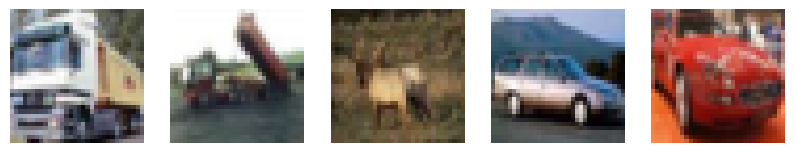

Shape of an image: (3, 32, 32)


In [137]:
x_train_val_np_color, y_train_val_np_color = load_cifar10(train=True, color=True)
x_test_np_color, y_test_np_color = load_cifar10(train=False, color=True)
plot_images(x_train_val_np_color, y_train_val_np_color, rows=1, cols=5, color=True)
print(f'Shape of an image: {x_train_val_np_color[0].shape}')

In [138]:
class LeNet5Color(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet5Color, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(400, 120)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(120, 84)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(84, num_classes)

    def forward(self, x):
        out = self.layer1(x)  # Second dimension is for channels, but we only have one channel.
        out = self.layer2(out)
        out = self.flatten(out)
        out = self.fc(out)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

# Exercise 11
### Split the data, create dataloaders, train an instance of `LeNet5Color`, and compare it with `LeNet5` using the test set.

In [139]:
x_train_np_color, x_val_np_color, y_train_np_color, y_val_np_color = train_test_split(
    x_train_val_np_color, y_train_val_np_color, train_size=40000,
    stratify=y_train_val_np_color, random_state=43,
)
print(x_train_np_color.shape)

(40000, 3, 32, 32)


In [140]:
x_train_color = torch.from_numpy(x_train_np_color).to(dtype=torch.float32)
y_train_color = torch.from_numpy(y_train_np_color).to(dtype=torch.int64)  # Class labels are usually integers

x_val_color = torch.from_numpy(x_val_np_color).to(dtype=torch.float32)
y_val_color = torch.from_numpy(y_val_np_color).to(dtype=torch.int64)

x_test_color = torch.from_numpy(x_test_np_color).to(dtype=torch.float32)
y_test_color = torch.from_numpy(y_test_np_color).to(dtype=torch.int64)
print(x_train_color.size())

torch.Size([40000, 3, 32, 32])


In [141]:
train_color = DataLoader(CustomDataset(x_train_color,y_train_color), batch_size=64, shuffle =True)

test_color = DataLoader(CustomDataset(x_test_color,y_test_color), batch_size=64, shuffle =True)

val_color = DataLoader(CustomDataset(x_val_color,y_val_color), batch_size=64, shuffle =True)

In [142]:
list_learning_rate = [0.001,0.0001, 1e-5,  1e-6 ,1e-7, 1e-8,  1e-9]
lr_rate_opt = fonction_renvoie_lr_rate(list_learning_rate =list_learning_rate,\
                                       device = device, modele = LeNet5Color, train = train_color,\
                                       val = val_color, number_class = None, loss_fn=loss_fn)
print(lr_rate_opt)

Le taux de learning est de 0.001
0-------------------
624 971.0558356046677

Validation set: 
  Accuracy: 50.2%, Avg loss: 1.377291 

1-------------------
624 810.7250182032585

Validation set: 
  Accuracy: 52.5%, Avg loss: 1.330273 

2-------------------
624 740.5806648135185

Validation set: 
  Accuracy: 54.5%, Avg loss: 1.271292 

3-------------------
624 690.3418020009995

Validation set: 
  Accuracy: 58.9%, Avg loss: 1.196456 

4-------------------
624 649.8410103321075

Validation set: 
  Accuracy: 60.5%, Avg loss: 1.122789 

5-------------------
624 615.1594572067261

Validation set: 
  Accuracy: 60.6%, Avg loss: 1.123664 

6-------------------
624 587.0130043625832

Validation set: 
  Accuracy: 61.0%, Avg loss: 1.140039 

7-------------------
624 565.7222177684307

Validation set: 
  Accuracy: 60.8%, Avg loss: 1.128985 

8-------------------
624 540.3675037026405

Validation set: 
  Accuracy: 63.6%, Avg loss: 1.046041 

9-------------------
624 519.1642889678478

Validation set

In [143]:
reseau_cnn_color = LeNet5Color().to(device)
optimizerNet = torch.optim.Adam(reseau_cnn_color.parameters(), lr = lr_rate_opt)

torch.manual_seed(133)

for epoch in range(0,10):
    print(str(epoch)+"-------------------")
    train_loop(dataloader=train_color,optimizer=optimizerNet,loss_fn=loss_fn,modele=reseau_cnn_color,device=device)
    evaluate_loop(dataloader=test_color,loss_fn=loss_fn,model=reseau_cnn_color,device=device)


0-------------------
624 971.0558356046677

Validation set: 
  Accuracy: 50.0%, Avg loss: 1.368531 

1-------------------
624 810.7250182032585

Validation set: 
  Accuracy: 52.8%, Avg loss: 1.320182 

2-------------------
624 740.5806648135185

Validation set: 
  Accuracy: 55.2%, Avg loss: 1.259036 

3-------------------
624 690.3418020009995

Validation set: 
  Accuracy: 58.0%, Avg loss: 1.185136 

4-------------------
624 649.8410103321075

Validation set: 
  Accuracy: 60.1%, Avg loss: 1.117086 

5-------------------
624 615.1594572067261

Validation set: 
  Accuracy: 61.2%, Avg loss: 1.103161 

6-------------------
624 587.0130043625832

Validation set: 
  Accuracy: 60.9%, Avg loss: 1.123868 

7-------------------
624 565.7222177684307

Validation set: 
  Accuracy: 60.9%, Avg loss: 1.116621 

8-------------------
624 540.3675037026405

Validation set: 
  Accuracy: 63.5%, Avg loss: 1.036832 

9-------------------
624 519.1642889678478

Validation set: 
  Accuracy: 62.2%, Avg loss: 1

# Comparaison of models

In [79]:
total_params_reseau_cnn_color=sum(p.numel() for p in reseau_cnn.parameters())
print(f'The number of parameters for  LeNet5Color model is {total_params_reseau_cnn_color}.')
print("The two models have the same performance.")

The number of parameter for  LeNet5Color model is 61750.
They have the same performance.


## Exercise 12
- Randomly take 10 examples from each class of CIFAR10 to make a subset (*) of the dataset.
- Load this model ResNet18 pre-trained on ImageNet v1 which is available from `torchvision.models`. See [this](https://pytorch.org/vision/stable/models.html) and [this documentation](https://pytorch.org/vision/stable/models/generated/torchvision.models.resnet18.html#torchvision.models.resnet18).
- Fine-tune the pre-trained model for 10-class classification with your subset (from (*)) of CIFAR10 (with colors). Train the model for 5 epochs.
- You may need to carefully read [this documentation](https://pytorch.org/vision/stable/models/generated/torchvision.models.resnet18.html#torchvision.models.resnet18) to do the right data pre-processing.

For this exercise, what is important is to have correct code. The final accuracy is less important, so you don't need to spend too much time on tuning hyper-parameters. There is a big difference in the image sizes, and it is challenging to make this transfer learning successful.

In [144]:
Base = load_cifar10(train = True)
print(type(Base))

<class 'tuple'>


# Creating of the train , validation and test data

In [145]:
x_train_res=[]
y_train_res=[]
test=[]
for y in np.unique(y_train_np_color):
    sous_ensemble=np.where(y_train_np_color==y)[0]
    indices=np.random.choice(sous_ensemble,10, replace =False )
    mini_x=x_train_np_color[indices]
    mini_y=y_train_np_color[indices]
    x_train_res.extend(mini_x)
    y_train_res.extend(mini_y)

x_train_res = np.array(x_train_res)
y_train_res = np.array(y_train_np)


In [146]:
def sample_grp_y(x_base,y_base):
    x_sample=[]
    y_sample=[]
    for y in np.unique(y_base):
        sous_ensemble=np.where(y_base==y)[0]
        indices=np.random.choice(sous_ensemble, 10, replace=False)
        mini_x=x_base[indices]
        mini_y=y_base[indices]
        x_sample.extend(mini_x)
        y_sample.extend(mini_y)
    x_sample=np.array(x_sample)
    y_sample=np.array(y_sample)
    return(x_sample,y_sample)

sample_x,sample_y=sample_grp_y(x_train_np_color,y_train_np_color)


In [147]:
sample_train_x,sample_test_x, sample_train_y,sample_test_y=train_test_split(sample_x,sample_y,random_state=6)
sample_train_x,sample_val_x,sample_train_y,sample_val_y=train_test_split(sample_train_x,sample_train_y,random_state=6)
print(sample_train_y.shape)

(56,)


In [148]:
sample_train_x=torch.from_numpy(sample_train_x).to(dtype=torch.float32)
sample_val_x=torch.from_numpy(sample_val_x).to(dtype=torch.float32)
sample_test_x=torch.from_numpy(sample_test_x).to(dtype=torch.float32)

sample_train_y=torch.from_numpy(sample_train_y).to(dtype=torch.int64)
sample_val_y=torch.from_numpy(sample_val_y).to(dtype=torch.int64)
sample_test_y=torch.from_numpy(sample_test_y).to(dtype=torch.int64)

In [149]:
from torchvision.models import resnet18

model = resnet18().to(device)

# Preprossessing

In [150]:
from torchvision.models import ResNet18_Weights
preprocess=ResNet18_Weights.DEFAULT.transforms()
## preprocessing
sample_train_x=preprocess(sample_train_x)
sample_val_x=preprocess(sample_val_x)
sample_test_x=preprocess(sample_test_x)

/opt/mamba/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [151]:
torch.manual_seed(133)

train_sample = DataLoader(CustomDataset(sample_train_x,sample_train_y), batch_size=10, shuffle =True)
test_sample = DataLoader(CustomDataset(sample_test_x,sample_test_y), batch_size=10, shuffle =True)
val_sample = DataLoader(CustomDataset(sample_val_x,sample_val_y), batch_size=10, shuffle =True)

# Turning of the model

In [152]:
list_learningRate = [0.001,0.0001, 1e-5,  1e-6 ,1e-7, 1e-8,  1e-9]

for learningRate in list_learningRate :
    model = resnet18().to(device)
    optimizerNet = torch.optim.Adam(model.parameters(), lr = learningRate)
    print(f"Le taux de learning est de {learningRate}")
    liste_precision=[]
    torch.manual_seed(133)
    for epoch in range(5):
        print(str(epoch)+"-------------------")
        train_loop(dataloader=train_sample,optimizer=optimizerNet,loss_fn=loss_fn,modele=model,device=device)
        precision = evaluate_loop(dataloader=val_sample,loss_fn=loss_fn,model=model,device=device)
        precision_un_taux.append(precision)
    selection=np.mean(np.array(precision_un_taux))
    liste_precision.append(selection)
indice=np.argmax(np.array(liste_precision))
lr_rate_optresnet=list_learning_rate[indice]

Le taux de learning est de 0.001
0-------------------
5 32.720848083496094

Validation set: 
  Accuracy: 10.5%, Avg loss: 916.887756 

1-------------------
5 18.799569845199585

Validation set: 
  Accuracy: 10.5%, Avg loss: 233.394897 

2-------------------
5 11.682804107666016

Validation set: 
  Accuracy: 5.3%, Avg loss: 25.279130 

3-------------------
5 10.854404091835022

Validation set: 
  Accuracy: 0.0%, Avg loss: 12.124784 

4-------------------
5 10.15961492061615

Validation set: 
  Accuracy: 10.5%, Avg loss: 20.120780 

Le taux de learning est de 0.0001
0-------------------
5 39.496646881103516

Validation set: 
  Accuracy: 10.5%, Avg loss: 16.763386 

1-------------------
5 31.40471839904785

Validation set: 
  Accuracy: 15.8%, Avg loss: 10.345893 

2-------------------
5 23.47116208076477

Validation set: 
  Accuracy: 10.5%, Avg loss: 7.077272 

3-------------------
5 18.435404062271118

Validation set: 
  Accuracy: 0.0%, Avg loss: 5.547614 

4-------------------
5 16.3242

# Computing the accuracy in the test data

In [153]:
model = resnet18().to(device)
optimizerNet = torch.optim.Adam(model.parameters(), lr = lr_rate_optresnet)
print(f"Le taux de learning est de {lr_rate_optresnet}")
liste_precision=[]

torch.manual_seed(133)

for epoch in range(5):
      print(str(epoch)+"-------------------")
      train_loop(dataloader=train_sample,optimizer=optimizerNet,loss_fn=loss_fn,modele=model,device=device)
      precision = evaluate_loop(dataloader=test_sample,loss_fn=loss_fn,model=model,device=device)

Le taux de learning est de 0.001
0-------------------
5 33.107598066329956

Validation set: 
  Accuracy: 20.0%, Avg loss: 480.656759 

1-------------------
5 18.566736936569214

Validation set: 
  Accuracy: 20.0%, Avg loss: 110.559371 

2-------------------
5 12.342234373092651

Validation set: 
  Accuracy: 20.0%, Avg loss: 61.661366 

3-------------------
5 10.621351718902588

Validation set: 
  Accuracy: 12.0%, Avg loss: 15.557113 

4-------------------
5 10.89992368221283

Validation set: 
  Accuracy: 20.0%, Avg loss: 4.666917 

